In [5]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
import pickle
import os


In [42]:
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
print(weekly_covid_df.head())

pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))

        date  confirmed_cases  confirmed_deaths
0 2020-02-23              4.0               0.0
1 2020-03-01             23.0               0.0
2 2020-03-08            131.0               0.0
3 2020-03-15            624.0               0.0
4 2020-03-22           1152.0               6.0
Total Population:  126014024
0.01% of Population:  126014


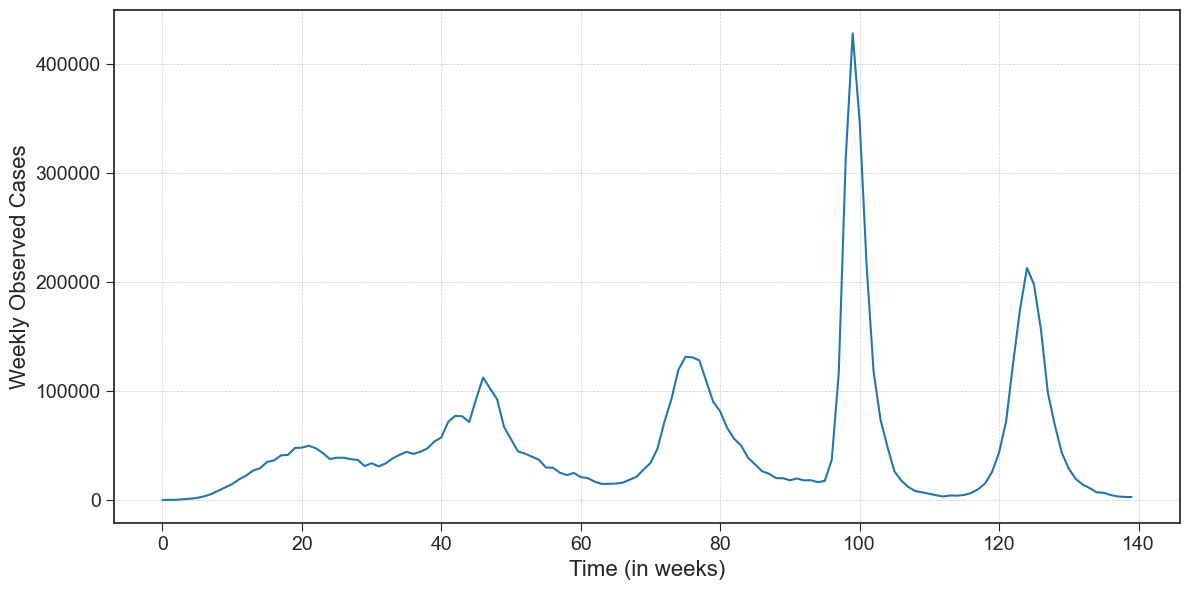

In [10]:
Y_obs = weekly_covid_df['confirmed_cases'].values[:140]

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(Y_obs)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [11]:
aux = Y_obs[Y_obs < np.quantile(Y_obs,0.9)]
overdispersion = (np.var(aux)-np.mean(aux))/np.mean(aux)**2
print(overdispersion)

0.6212418740345191


In [19]:
def BM_SEIR(V_in, params, num_particles, N, m):
    num_steps = m + 1  
    h = 1 / num_steps 

    # Initialize arrays to store results
    V = np.zeros([V_in.shape[0], num_particles, num_steps + 1])    
    new_infected = np.zeros([num_particles])

    # Set initial conditions
    kappa, gamma, sigma = params[:3]    
    V[:,:,0] = V_in

    # Simulate the SIR model with diffuse infectious rate using Euler-Maruyama method
    for t in range(1, num_steps + 1):
        # Update SEIR model
        infections = np.exp(V[4,:,t-1]) * V[0, :, t-1] * V[2, :, t-1] / N 
        latent = kappa * V[1, :, t-1]
        recovered = gamma * V[2, :, t-1]
        
        V[0, :, t] = V[0, :, t-1] - infections*h                  # S-Susceptibles
        V[1, :, t] = V[1, :, t-1] + (infections  - latent) * h    # E-Exposed
        V[2, :, t] = V[2, :, t-1] + (latent - recovered)*h        # I-Infected
        V[3, :, t] = V[3, :, t-1] + recovered*h                   # R-Recovered
        
        # Update Latent State
        dB = stats.norm(0, 1).rvs(num_particles)
        V[4,:,t] = V[4,:,t-1] + sigma * np.sqrt(h) * dB
        
        # Update weekly infected count
        new_infected += infections*h 
    
    return V[:,:,-1], new_infected

In [21]:
def BPF(Y_obs, N, T, num_particles, params, initial_conditions, BM_SEIR, m):
    
    # Initialize BPF variables
    particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
    weekly_infections = np.zeros([num_particles, T+1])

    weights = np.zeros([num_particles, T+1])
    norm_weights = np.zeros([num_particles, T+1])

    ancestry_matrix = np.zeros([num_particles, T+1])
    ESS = np.zeros(T+1)
    loglikelihood = 0

    # Define values at time t=0
    particles[:, :, 0] = initial_conditions
    weekly_infections[:,0] = particles[2, :, 0]

    weights[:,0] = 1 / num_particles
    norm_weights[:,0] = weights[:,0]
    ESS[0] = num_particles

    ancestry_matrix[:,0] = np.arange(num_particles)

    for t in range(1,T+1):
        # Resample particles using Systematic Resampling
        r = stats.uniform(0,1).rvs()
        positions =  (np.arange(num_particles) + r )/num_particles
        resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t-1]), positions)
        ancestry_matrix[:,1:t-1] = ancestry_matrix[resample_indices,1:t-1]
        ancestry_matrix[:,t] = resample_indices
        
        # Propagate particles to next week
        particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:, resample_indices, t-1], params, num_particles, N, m)

        # Update particle weights
        #incremental_weights = stats.norm(np.log(Y_obs[t]), 0.05).logpdf(np.log(weekly_infections[:,t]))
        incremental_weights = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,t])).logpmf(Y_obs[t])

        max_weights = np.max(incremental_weights)
        weights[:,t] = np.exp(incremental_weights - max_weights)
        sum_weights = weights[:,t].sum()
        norm_weights[:,t] = weights[:,t] / sum_weights
        
        ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
        loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)

        if np.isnan(loglikelihood):
            break
                
    if norm_weights[:,-1].sum() != 1:
        chosen_index = np.random.choice(a=np.arange(num_particles), size=1, p=np.ones(num_particles)/num_particles)
    else:
        chosen_index = np.random.choice(a=np.arange(num_particles), size=1, p=norm_weights[:, -1])
    
    return loglikelihood, weekly_infections[ancestry_matrix[chosen_index, -1].astype(int),:], particles[:,ancestry_matrix[chosen_index, -1].astype(int),:]

In [12]:
m = 0
T = Y_obs.shape[0]-1
num_particles = 3000
num_iterations = 150000

# initial_conditions = np.repeat(V_in,num_particles).reshape(5,num_particles) #Sationary Initial Conditions
E0 = stats.uniform(0,0.0001*N).rvs(num_particles)
I0 = np.ones(num_particles)*Y_obs[0]
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,2).rvs(num_particles))
    ])

current_theta = np.array([
    stats.beta(11.4, 2.5).rvs(),
    stats.beta(12.1, 10.3).rvs(),
    stats.uniform(0,1).rvs()
])

stepSize = np.diag([
    0.1**2,
    0.1**2,
    0.1**2,
])

print('Initial conditions: ',np.mean(initial_conditions, axis=1))
print('Initial parameters: ',current_theta)

Initial conditions:  [ 1.26007725e+08  6.29508384e+03  4.00000000e+00  0.00000000e+00
 -3.24631604e-01]
Initial parameters:  [0.88264811 0.61999689 0.08034595]


In [79]:
theta_samples = np.zeros([current_theta.shape[0],num_iterations])
weekly_trajectories = np.zeros([T+1,num_iterations])
vector_trajectories = np.zeros([initial_conditions.shape[0],T+1,num_iterations])
loglikelihoods = np.zeros(num_iterations)

rejected_count = 0
acceptance_count = 0
AccRate = 0

current_loglik, current_weekly, current_vectors  = BPF(Y_obs, N, T, num_particles, current_theta, initial_conditions, BM_SEIR, m)

print("Initial parameters:", current_theta)
print("Initial log-likelihood:", current_loglik)

theta_samples[:,0] = current_theta
loglikelihoods[0] = current_loglik
weekly_trajectories[:,0] = current_weekly
vector_trajectories[:,:,0] = current_vectors[:,0,:]

for i in range(1,num_iterations):
    proposed_theta = theta_samples[:, i-1] + stats.multivariate_normal(mean=np.zeros(current_theta.shape[0]), cov=stepSize).rvs()
    
    if (proposed_theta[0] < 0) or (proposed_theta[0] > 1) or (proposed_theta[1] < 0) or (proposed_theta[1] > 1)  or (proposed_theta[2] < 0) or (proposed_theta[2] > 1):
        rejected_count += 1
        proposed_loglik = -np.inf
        accept_prob = 0
    else:
        proposed_loglik, proposed_weekly, proposed_vectors  = BPF(Y_obs, N, T, num_particles, proposed_theta, initial_conditions, BM_SEIR,m)
        prior_ratio = stats.beta(11.4, 2.5).logpdf(proposed_theta[0]) - stats.beta(11.4, 2.5).logpdf(theta_samples[0,i-1])
        prior_ratio += stats.beta(12.1, 10.3).logpdf(proposed_theta[1]) - stats.beta(12.1, 10.3).logpdf(theta_samples[1,i-1])
        log_lik_ratio = proposed_loglik - loglikelihoods[i-1]
        accept_prob = min(1,np.exp(log_lik_ratio + prior_ratio))
    
    if stats.uniform(0,1).rvs() < accept_prob:
        theta_samples[:,i] = proposed_theta
        weekly_trajectories[:,i] = proposed_weekly
        vector_trajectories[:,:,i] = proposed_vectors[:,0,:]
        
        loglikelihoods[i] = proposed_loglik
        acceptance_count += 1
    else:
        theta_samples[:,i] = theta_samples[:,i-1]
        weekly_trajectories[:,i] = weekly_trajectories[:,i-1]
        vector_trajectories[:,:,i] = vector_trajectories[:,:,i-1]

        loglikelihoods[i] = loglikelihoods[i-1]
        
    AccRate = acceptance_count / (i + 1)
    
    if i == 1000:
        print(f"Iteration {i}: Acceptance Rate = {AccRate:.2%}")
        print('Rejected Samples: ', rejected_count)
        
    if i % 10000 == 0:
        print(f"Iteration {i}: Acceptance Rate = {AccRate:.2%}")
        print('Rejected Samples: ', rejected_count)

Initial parameters: [0.85719568 0.63824902 0.31940972]
Initial log-likelihood: -1583.7555228221229
Iteration 1000: Acceptance Rate = 27.37%
Rejected Samples:  102
Iteration 10000: Acceptance Rate = 26.59%
Rejected Samples:  1003
Iteration 20000: Acceptance Rate = 26.59%
Rejected Samples:  1920
Iteration 30000: Acceptance Rate = 26.23%
Rejected Samples:  2883
Iteration 40000: Acceptance Rate = 26.19%
Rejected Samples:  3796
Iteration 50000: Acceptance Rate = 26.20%
Rejected Samples:  4832
Iteration 60000: Acceptance Rate = 26.14%
Rejected Samples:  5738
Iteration 70000: Acceptance Rate = 26.10%
Rejected Samples:  6698
Iteration 80000: Acceptance Rate = 26.12%
Rejected Samples:  7661
Iteration 90000: Acceptance Rate = 26.09%
Rejected Samples:  8593
Iteration 100000: Acceptance Rate = 26.02%
Rejected Samples:  9618
Iteration 110000: Acceptance Rate = 25.98%
Rejected Samples:  10622
Iteration 120000: Acceptance Rate = 26.04%
Rejected Samples:  11547
Iteration 130000: Acceptance Rate = 26.1

In [80]:
import os
import pickle

# Define the folder path
data_folder = '/Users/ro/Desktop/Undergrad_AM_Thesis/Notebooks'

# Define the full path for the file
file_path = os.path.join(data_folder, 'v2_covid_final_results.pkl')

# Save the pickle file
results = {
    'theta_samples': theta_samples,
    'weekly_trajectories': weekly_trajectories,
    'vector_trajectories': vector_trajectories,
    'loglikelihoods': loglikelihoods,
    'acceptance_count': acceptance_count,
    'rejected_count': rejected_count,
    'AccRate': AccRate
}

with open(file_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Final results saved to {file_path}")

Final results saved to /Users/ro/Desktop/Undergrad_AM_Thesis/Notebooks/v2_covid_final_results.pkl


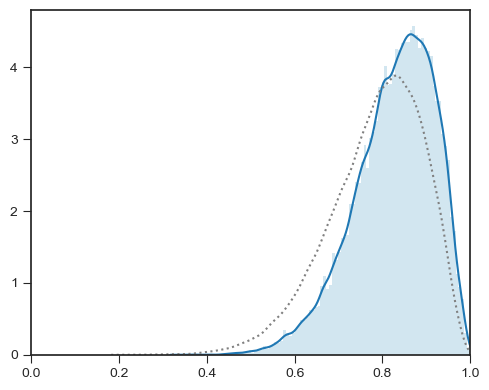

0.8267396210971156


In [84]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[0, 50000:], 
    bins=100, 
    color=colors[0], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[0,50000:], linewidth=1.5, color=colors[1])
sns.kdeplot(stats.beta(11, 3).rvs(100000),linewidth=1.5, color='grey', linestyle=':')
plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()
print(np.mean(theta_samples[0, 50000:]))

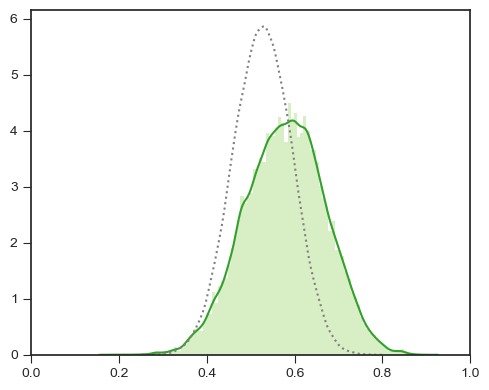

0.5784117116124462


In [86]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[1, 50000:], 
    bins=100, 
    color=colors[2], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[1,50000:], linewidth=1.5, color=colors[3])
sns.kdeplot(stats.beta(29.2, 26.2).rvs(100000),linewidth=1.5, color='grey', linestyle=':')

plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()

print(np.mean(theta_samples[1, 50000:]))

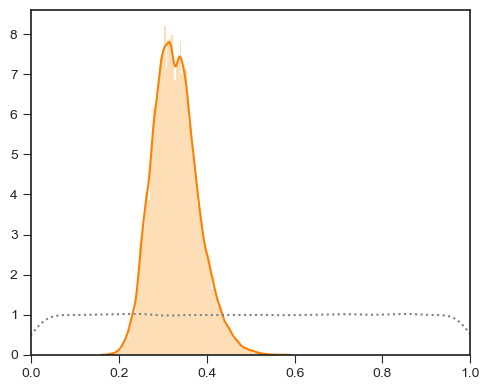

0.32497724868964534


In [88]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[2, 50000:], 
    bins=100, 
    color=colors[6], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[2,50000:], linewidth=1.5, color=colors[7])
sns.kdeplot(stats.uniform(0,1).rvs(100000),linewidth=1.5, color='grey', linestyle=':')

plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()

print(np.median(theta_samples[2, 50000:]))

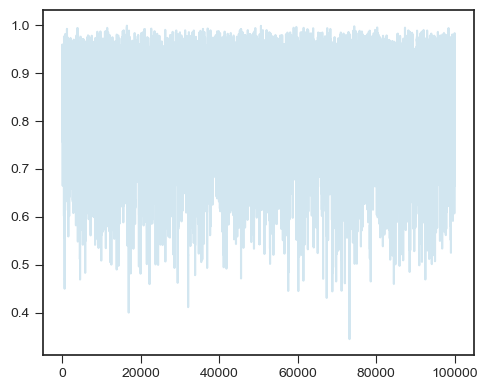

In [89]:
plt.figure(figsize=(5, 4))

plt.plot(theta_samples[0,50000:], color=colors[0], alpha=0.5)
plt.tight_layout()
plt.show()

In [100]:
def geweke_test(chain, first_frac=0.2, last_frac=0.5):
    """
    Compute the Geweke diagnostic for MCMC convergence.
    
    Parameters:
    - chain: 1D array of MCMC samples.
    - first_frac: Fraction of the chain for the early section (e.g., 0.1).
    - last_frac: Fraction of the chain for the later section (e.g., 0.5).
    
    Returns:
    - Z-score: Test statistic for comparing means of the two sections.
    """
    n = len(chain)
    first_samples = chain[:int(first_frac * n)]
    last_samples = chain[int((1 - last_frac) * n):]
    
    mean_first = np.mean(first_samples)
    mean_last = np.mean(last_samples)
    
    var_first = np.var(first_samples, ddof=1) / len(first_samples)
    var_last = np.var(last_samples, ddof=1) / len(last_samples)
    
    z_score = (mean_first - mean_last) / np.sqrt(var_first + var_last)
    return z_score

# Example usage
z_score = geweke_test(theta_samples[1,50000:])
print(f"Geweke Z-score: {z_score}")


Geweke Z-score: 4.137011256836119


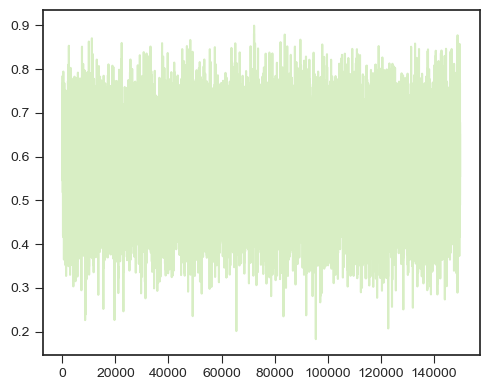

In [83]:
plt.figure(figsize=(5, 4))

plt.plot(theta_samples[1,50000:], color=colors[2], alpha=0.5)

plt.tight_layout()
plt.show()

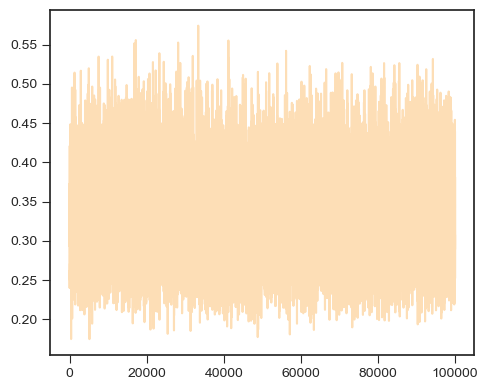

In [91]:
plt.figure(figsize=(5, 4))

plt.plot(theta_samples[2,50000:], color=colors[6], alpha=0.5)

plt.tight_layout()
plt.show()

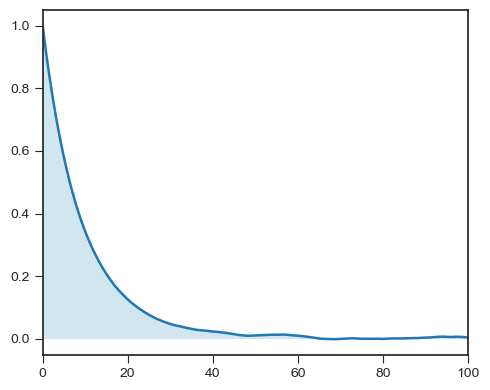

In [92]:
autocorr = acf(theta_samples[0,50000:], nlags=100, fft=True)

plt.figure(figsize=(5, 4))
plt.plot(autocorr, color=colors[1], linewidth=1.8)
plt.bar(range(100 + 1), autocorr, color=colors[0], width=1, alpha=0.5)

plt.xlim(0,100)
plt.tight_layout()
plt.show()

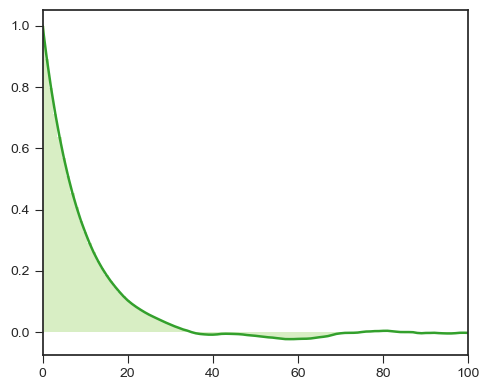

In [93]:
autocorr = acf(theta_samples[1,50000:], nlags=100, fft=True)

plt.figure(figsize=(5, 4))
plt.plot(autocorr, color=colors[3], linewidth=1.8)
plt.bar(range(100 + 1), autocorr, color=colors[2], width=1, alpha=0.5)

plt.xlim(0,100)
plt.tight_layout()
plt.show()

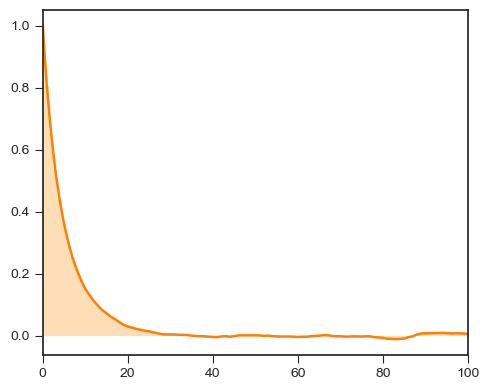

In [94]:
autocorr = acf(theta_samples[2,50000:], nlags=100, fft=True)

plt.figure(figsize=(5, 4))
plt.plot(autocorr, color=colors[7], linewidth=1.8)
plt.bar(range(100 + 1), autocorr, color=colors[6], width=1, alpha=0.5)

plt.xlim(0,100)
plt.tight_layout()
plt.show()

In [31]:
# Define the folder path
data_folder = '/Users/ro/Desktop/Undergrad_AM_Thesis/Notebooks'

# Define the full path for the file
file_path = os.path.join(data_folder, 'v2_covid_final_results.pkl')

# Load the pickle file
with open(file_path, 'rb') as f:
    results = pickle.load(f)

# Access the data from the dictionary
theta_samples = results['theta_samples']
weekly_trajectories = results['weekly_trajectories']
vector_trajectories = results['vector_trajectories']
loglikelihoods = results['loglikelihoods']
acceptance_count = results['acceptance_count']
rejected_count = results['rejected_count']
AccRate = results['AccRate']

# Print a summary of the loaded data
print(f"Theta Samples Shape: {theta_samples.shape}")
print(f"Acceptance Rate: {AccRate:.2%}")
print(f"Number of Rejected Samples: {rejected_count}")

Theta Samples Shape: (3, 150000)
Acceptance Rate: 26.23%
Number of Rejected Samples: 14360


In [32]:
RT = np.zeros([T+1, 100000])
for t in range(T+1):
    RT[t] = np.exp(vector_trajectories[4,t,50000:]) / (theta_samples[1,50000:])*vector_trajectories[0,t,50000:]/N

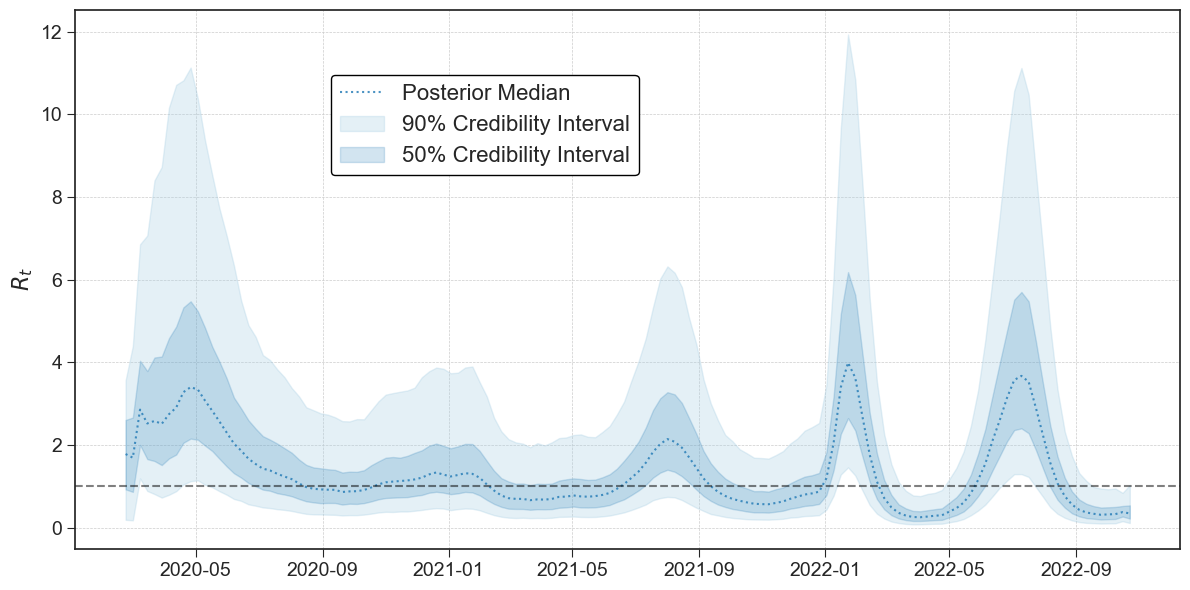

In [104]:
RT_median = np.median(RT, axis=1)
# Compute the 5th and 95th percentiles for the 90% probability interval
RT_5th = np.percentile(RT, 5, axis=1)
RT_95th = np.percentile(RT, 95, axis=1)

RT_25th = np.percentile(RT, 25, axis=1)
RT_75th = np.percentile(RT, 75, axis=1)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

plt.plot(weekly_covid_df['date'][:140],RT_median, color=colors[1], alpha=0.8, linestyle=':', label='Posterior Median')
plt.fill_between(weekly_covid_df['date'][:140], RT_5th, RT_95th, 
                 color=colors[0], alpha=0.3, label='90% Credibility Interval')
plt.fill_between(weekly_covid_df['date'][:140], RT_25th, RT_75th, 
                 color=colors[1], alpha=0.2, label='50% Credibility Interval')
plt.axhline(1, color='black', alpha=0.5, linestyle='--')
plt.legend(
    bbox_to_anchor=(0.52, 0.9),
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.ylabel(r'$R_t$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

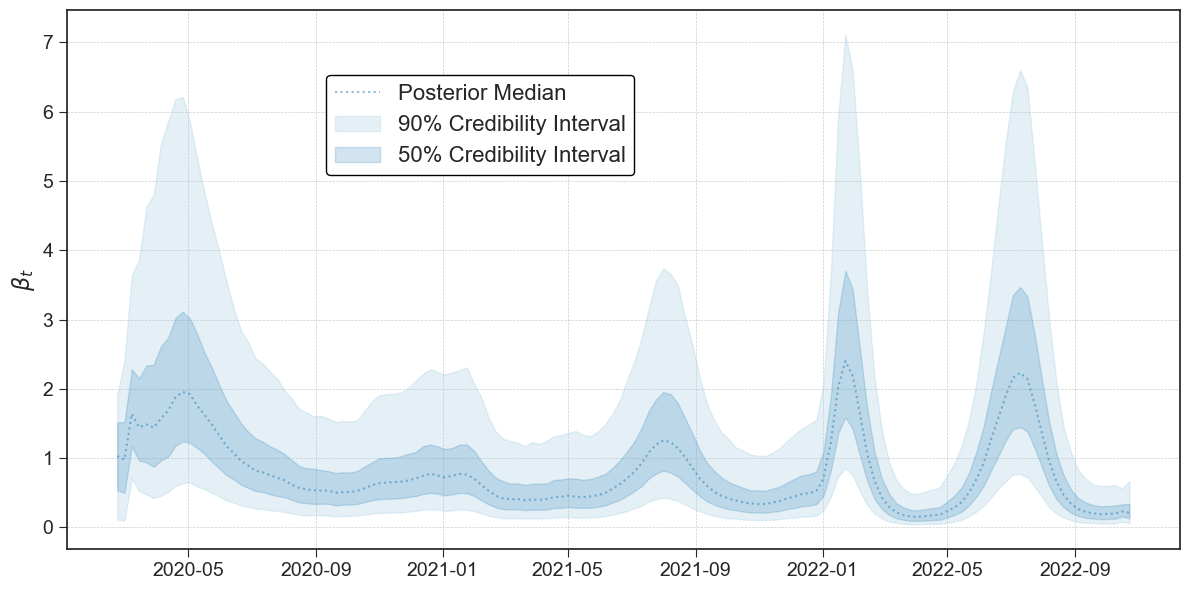

In [103]:
beta_lineage = np.exp(vector_trajectories[-1,:,50000:])

beta_median = np.median(beta_lineage, axis=1)
# Compute the 5th and 95th percentiles for the 90% probability interval
beta_5th = np.percentile(beta_lineage, 5, axis=1)
beta_95th = np.percentile(beta_lineage, 95, axis=1)

beta_25th = np.percentile(beta_lineage, 25, axis=1)
beta_75th = np.percentile(beta_lineage, 75, axis=1)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

plt.plot(weekly_covid_df['date'][:140], beta_median, color=colors[1], alpha=0.5, linestyle=':', label='Posterior Median')
plt.fill_between(weekly_covid_df['date'][:140], beta_5th, beta_95th, 
                 color=colors[0], alpha=0.3, label='90% Credibility Interval')
plt.fill_between(weekly_covid_df['date'][:140], beta_25th, beta_75th, 
                 color=colors[1], alpha=0.2, label='50% Credibility Interval')

plt.legend(
    bbox_to_anchor=(0.52, 0.9),
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.ylabel(r'$\beta_t$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

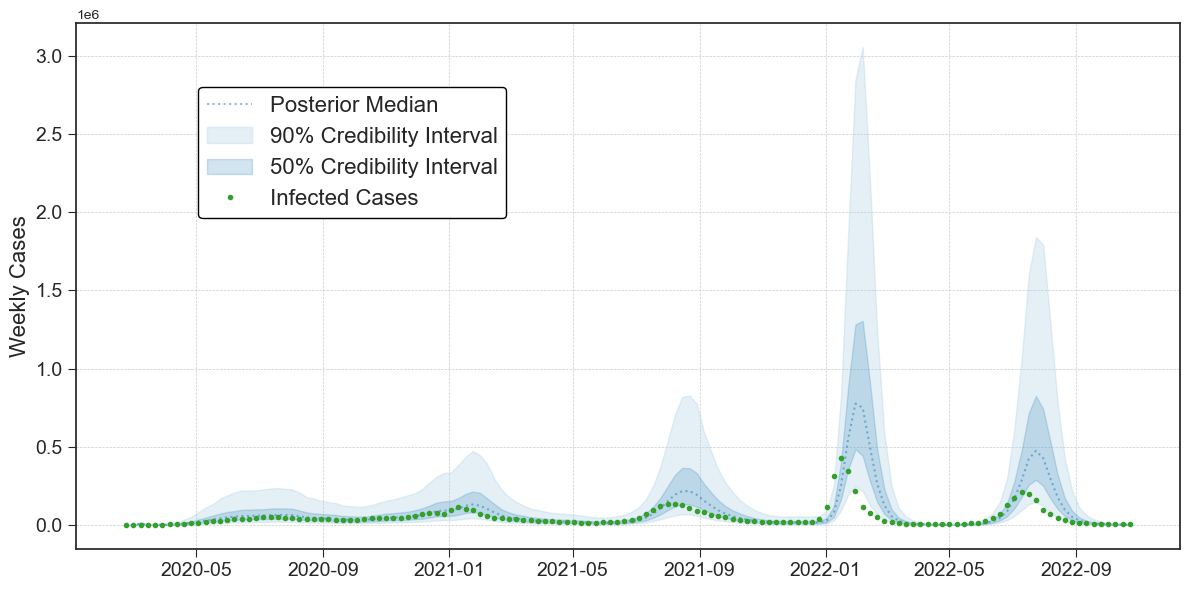

In [102]:
infections_lineage = weekly_trajectories[:,50000:]

infections_median = np.median(infections_lineage, axis=1)
# Compute the 5th and 95th percentiles for the 90% probability interval
infections_5th = np.percentile(infections_lineage, 5, axis=1)
infections_95th = np.percentile(infections_lineage, 95, axis=1)

infections_25th = np.percentile(infections_lineage, 25, axis=1)
infections_75th = np.percentile(infections_lineage, 75, axis=1)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

plt.plot(weekly_covid_df['date'][:140],infections_median, color=colors[1], alpha=0.5, linestyle=':', label='Posterior Median')
plt.fill_between(weekly_covid_df['date'][:140], infections_5th, infections_95th, 
                 color=colors[0], alpha=0.3, label='90% Credibility Interval')
plt.fill_between(weekly_covid_df['date'][:140], infections_25th, infections_75th, 
                 color=colors[1], alpha=0.2, label='50% Credibility Interval')
plt.plot(weekly_covid_df['date'][:140],Y_obs, color=colors[3], label='Infected Cases', marker='o', linewidth=0, markersize=3)
plt.legend(
    bbox_to_anchor=(0.4, 0.9),
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.ylabel('Weekly Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()